In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, model_selection
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics.pairwise import pairwise_kernels

import scipy

# Train model

In [2]:
B = pd.read_parquet("./data/B_HKML.parquet")
all_epochs = B.date.unique()
batch_size = 10
epochs = all_epochs[:batch_size]

i = B.shape[1] - 1
j = 0
for epoch in epochs:
    B_np = B[B["date"] == epoch].drop("date", axis=1).to_numpy().T
    j += B_np.shape[1]

Batch_B = np.zeros((i, j))

j = 0
for epoch in epochs:
    B_np = B[B["date"] == epoch].drop("date", axis=1).to_numpy().T
    dj = B_np.shape[1]
    Batch_B[:, j : j + dj] = B_np

    j += dj
B_train = Batch_B

# plt.figure(figsize=(15, 10))
# sns.heatmap(np.abs(B))
# plt.show()

X_df = pd.read_parquet("./data/X_HKML.parquet")
X_train = X_df[X_df["date"].isin(epochs)].drop("date", axis=1).to_numpy()

# Gaussianize Target

In [4]:
import sys

sys.path.insert(1, "../../Feature engg/feature-engineering/src")
from class_ import Data

y_df = pd.read_parquet("./data/Y_HKML.parquet")

In [5]:
y_date = pd.concat([X_df["date"], y_df], axis=1)

In [6]:
data = Data(f_matrix=y_date, b_matrix=B)

In [7]:
data.gaussianize()

  0%|          | 0/1 [00:00<?, ?it/s]

0

In [8]:
data.standardize()

  0%|          | 0/1 [00:00<?, ?it/s]

0

In [9]:
y_date = data.f_matrix

In [10]:
y_df = y_date.iloc[:, 1]

In [11]:
y_train = y_df.iloc[: len(X_train)].to_numpy().ravel()

In [12]:
# Values of C and D to be fine tuned to have good mse out of sample and good orthogonality out of sample?
C = 3.0
D = 100.0

K = pairwise_kernels(X_train, metric="rbf")
BBK = B_train.T @ B_train @ K
M = K + C * np.identity(K.shape[0]) + D * BBK
dual_coef = np.linalg.solve(M, y_train)

# Estimate

In [16]:
future_moons = 5

In [17]:
y_hat_df = pd.DataFrame()
y_hat_df["date"] = X_df[
    X_df["date"].isin(all_epochs[batch_size : batch_size + future_moons])
].date
y_hat_df["y_hat"] = np.nan
y_hat_df["y_test"] = np.nan

In [18]:
for moon in tqdm(range(future_moons)):
    epochs = all_epochs[0 : batch_size + moon + 1]

    j = 0
    for epoch in epochs:
        B_np = B[B["date"] == epoch].drop("date", axis=1).to_numpy().T
        j += B_np.shape[1]

    Batch_B = np.zeros((i, j))

    j = 0
    for epoch in epochs:
        B_np = B[B["date"] == epoch].drop("date", axis=1).to_numpy().T
        dj = B_np.shape[1]
        Batch_B[:, j : j + dj] = B_np

        j += dj
    B_test = Batch_B

    X_test = X_df[X_df["date"].isin(epochs)].drop("date", axis=1).to_numpy()

    y_test = y_df.iloc[: len(X_test)].to_numpy().ravel()

    K_hat = pairwise_kernels(X_test, X_train, metric="rbf")

    y_hat = K_hat @ dual_coef

    exp_vec = B_test @ y_hat
    exp = np.dot(exp_vec, exp_vec)

    # print('Factor Exposure')
    # print(exp)
    # leastsquare = np.dot(y_test - y_hat, y_test - y_hat)
    # print('Least Square Error')
    # print(leastsquare)
    # ridge = K_hat @ dual_coef
    # print('Regularization Loss')
    # print(np.dot(ridge, ridge))

    y_hat_df.loc[y_hat_df["date"] == epochs[-1], "y_hat"] = y_hat[-dj:]
    y_hat_df.loc[y_hat_df["date"] == epochs[-1], "y_test"] = y_test[-dj:]

100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


In [19]:
def spear(x):
    pear = x.corr(numeric_only=True)
    pear = pear.iloc[0, 1]
    spear = x.corr(numeric_only=True, method="spearman")
    spear = spear.iloc[0, 1]
    return spear

In [20]:
metrics_history = y_hat_df.groupby("date").apply(lambda x: spear(x))

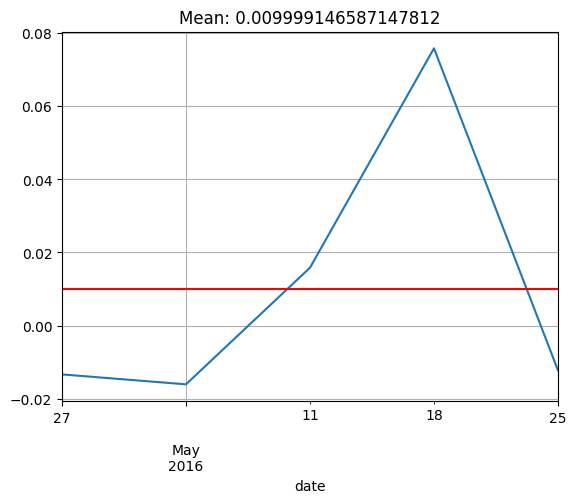

In [21]:
metrics_history.plot(grid="on")
plt.axhline(y=metrics_history.mean(), color="r", linestyle="-")
plt.title(f"Mean: {metrics_history.mean()}")
plt.show()